This project uses three different neural networks (Dense Model, LSTM Model and Convolutional model) in Keras to perform Sentiment Analysis on Amazon book reviews, classifying them as either positive or negative. The models used are compared based on their performance, with a small dataset of positive and negative book reviews from Amazon being utilized.

###  Get and explore dataset

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import re

In [49]:
# Make results reproducible - set random seed
from numpy.random import seed
seed(42)

In [50]:
positive_file = "positive.txt"
negative_file = "negative.txt"

In [51]:
# Helper function to load and preprocess data
def filter_words(line):    
    line = re.sub(r'[^\w\s]','',line.rstrip())
    words = line.split(" ") 
    words = [i.lower() for i in words if i]      
    return " ".join(words)

def load_data(filename):
    thefile = open(filename, 'r') 
    lines = thefile.readlines() 

    data = []
    for l in range(0,len(lines)): 
        if(lines[l-1].strip() == "<title>"): 
            theline = filter_words(lines[l])
            if(len(theline) < 50):
                data.append(theline)            
            
    return data

# Helper function to convert categorical data to class label
def to_word_label(y):
    y = to_class(y)   
    return ["positive" if i==0 else "negative" for i in y]

# Helper function to convert class label to numeric label
def to_numeric_label(y):
  return [0 if i=="positive" else 1 for i in word_labels]

# Helper function: needs to be called before sending arrays to sklearn metrics,
# it converts back to class form from categorical form. ie: [1,0] --> 0, [0,1] --> 1
def to_class(y):
    return np.argmax(y,axis=1) 

In [52]:
positive = load_data(positive_file)
negative = load_data(negative_file)

print(positive[0:10])
print(negative[0:10])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book', 'to the point and beautifully illustrated', 'at least somebody has got it', 'beautifully written heartwarming story', 'an excellent cookbook full of delicious recipes', 'an outstanding resource']
['horrible book horrible', 'shallow selfindulgence', 'horrible book horrible', 'disappointment', 'a disappointing mess', 'save your money there are better books out there', 'thank you but no thanks', 'unendurable', 'the hard way', 'some good info among the political commercial']


In [53]:
print(f"There are {len(positive)} positive reviews and {len(negative)} negative reviews.")

There are 872 positive reviews and 921 negative reviews.


After merging positive and negative reviews in a single dataset, we achieve a balanced dataset with an approximately equal number of samples in each class.

In [54]:
# Combine the positive and negative reviews into a single list and create labels
data = positive + negative
word_labels = ["positive"] * len(positive) + ["negative"] * len(negative) 

# Converts labels to numbers in one-hot encoding - [1, 0] (positive) or [0, 1] (negative)
from keras.utils import to_categorical
labels  = to_categorical(to_numeric_label(word_labels))

Mean Review length: 4
Standard Deviation: 2


{'whiskers': [<matplotlib.lines.Line2D at 0x1fb369af580>,
 'caps': [<matplotlib.lines.Line2D at 0x1fb369afc10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fb369af4f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1fb23ffe340>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fb23ffe6a0>],
 'means': []}

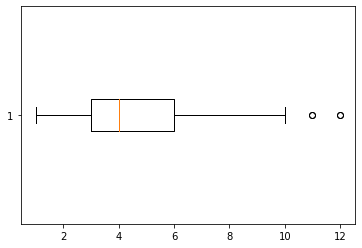

In [55]:
# Calculate the mean review size, its standard deviation and create a boxplot.

# calculate mean review size
lengths = [len(i.split()) for i in data]
mean_review_size = round(np.mean(lengths))

print("Mean Review length:", mean_review_size)
print("Standard Deviation:", round(np.std(lengths))) 

plt.boxplot(lengths, vert=False)

As we can observe from the plot above, the mean length of review sentiments is 4, with 75% of sentiments being shorter than 6 words.

In [56]:
# Calculate the number of unique words in the dataset
words = " ".join(data).split()
print("The number of unique words in the dataset: ", len(np.unique(words)))

The number of unique words in the dataset:  2559


## Pre-processing

In [57]:
# Tokenize the vocabulary 
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=50+1)  # ids of the 50 most  frequent words is returned
tokenizer.fit_on_texts(data)         # create the vocabularry
tokenized_data = tokenizer.texts_to_sequences(data)  # encode the reviews in the training dataset

vocab_size = len(tokenizer.word_index)

# Compare original and tokenized data
print(data[0:5])
print(tokenized_data[0:5])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book']
[[18, 4, 2, 19], [2, 4, 2], [], [6, 4], [1, 12, 3]]


In [58]:
from keras.utils import pad_sequences

# Pre-process the data so that each sentiment is the same length (= mean_review_size)
X = pad_sequences(tokenized_data, padding='post', maxlen=mean_review_size)

# Now all sentiments will have the same length as mean_review_size

In [59]:
# Split data into 80% training and 20% test sets with shuffling

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, shuffle=True, random_state=42)

print(f"X_train, y_train: {X_train.shape},{y_train.shape}")
print(f"X_test, y_test: {X_test.shape},{y_test.shape}")

X_train, y_train: (1434, 4),(1434, 2)
X_test, y_test: (359, 4),(359, 2)


In [108]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# The following function
# - makes a prediction for the test set given the model
# - reports the precision, recall and f1 score. 
# - uses the helper to_class function to convert y_pred and y_test before supplying them to the sklearn functions.

def assess_model(model, X_test, y_test):      
    y_pred = model.predict(X_test, verbose=0)
    
    y_test_class = to_class(y_test)
    y_pred_class = to_class(y_pred)

    accuracy = accuracy_score(y_test_class, y_pred_class)*100
    precision = precision_score(y_test_class, y_pred_class)
    recall = recall_score(y_test_class, y_pred_class)
    f1 = f1_score(y_test_class, y_pred_class)

   
    def format_score(score):
        return round(score, 2)

    print(f"Accuracy:  {format_score(accuracy)}%")
    print("precision score: ", format_score(precision))
    print("recall score: ", format_score(recall))
    print("F1 score: ", format_score(f1))
     

In [97]:
def plot_accuracy(history):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,3))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('Adam optimizer loss')
    ax1.grid(True)
    
    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('Accuracy')
    plt.grid(True)
    
    plt.show()    

## Build and tune models

We construct and train three different models, subsequently comparing their performances to determine the best-performing model on our dataset. The first model we consider is a simple Dense model, also known as a Feed-forward Neural Network.

**Simple Dense model**

In [98]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

output_dim = 32
lr = 0.001

model_d = Sequential()
model_d.add(layers.Embedding(input_dim=vocab_size, output_dim=output_dim))
model_d.add(layers.GlobalMaxPooling1D())
model_d.add(layers.Dense(2, activation='softmax'))

model_d.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
model_d.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, None, 32)          81888     
                                                                 
 global_max_pooling1d_9 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_38 (Dense)            (None, 2)                 66        
                                                                 
Total params: 81,954
Trainable params: 81,954
Non-trainable params: 0
_________________________________________________________________


In [99]:
history_d = model_d.fit(X_train, y_train, epochs=20, batch_size=32, validation_split = 0.2, verbose=0)

In [109]:
assess_model(model_d, X_test, y_test)

Accuracy:  64.07%
precision score:  0.65
recall score:  0.64
F1 score:  0.64


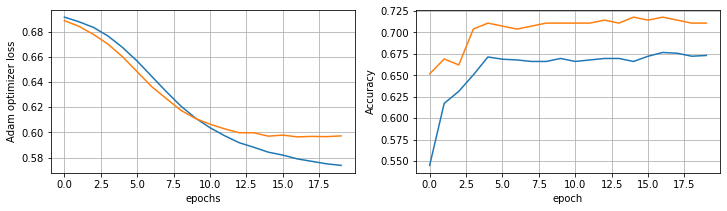

In [95]:
plot_accuracy(history_d)

**LSTM model**

In [66]:
dropout_rate = 0.2 
epochs = 20

In [67]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

def build_model_lstm(vocab_size, output_dim, dropout_rate, lr):
    """
    Build and compile a model.
    Parameters: 
        vocab_size (int): The total number of unique words in the vocabulary of the input data.
        output_dim (int): Dimension of a vector space in the Embedding layer. 
        lr (float): The learning rate.
    Return: 
        A compiled Keras model."""    
    
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=output_dim))
    model.add(layers.SpatialDropout1D(dropout_rate))
    model.add(layers.BatchNormalization())
    model.add(layers.LSTM(64))
    model.add(layers.Dense(2, activation='softmax'))
    
    # compile model
    model.compile(optimizer = Adam(lr), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.summary()
    
    return model    

In [68]:
model_lstm = build_model_lstm(vocab_size, output_dim, dropout_rate, lr)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_1 (Spatia  (None, None, 32)         0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_1 (Batc  (None, None, 32)         128       
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 106,978
Trainable params: 106,914
Non-tr

In [91]:
batch_size=32

hystory_lstm = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split = 0.2,verbose=0)

In [70]:
assess_model(model_lstm, X_test, y_test)

accuracy score:  0.6435
precision score:  0.6341
recall score:  0.7104
F1 score:  0.6701



output_dim 16, dropout_rate 0.2, lr 0.001, batch size 32, 30 epochs
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, None, 16)          40944     
                                                                 
 spatial_dropout1d_28 (Spati  (None, None, 16)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_28 (Bat  (None, None, 16)         64        
 chNormalization)                                                
                                                                 
 lstm_28 (LSTM)              (None, 64)                20736     
                                                                 
 dense_39 (Dense)            (None, 2)                 130       
                                                  

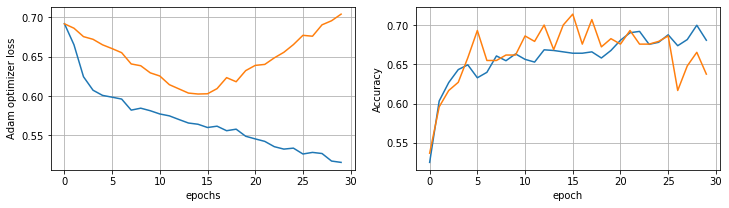


output_dim 32, dropout_rate 0.2, lr 0.001, batch size 32, 30 epochs
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_29 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_29 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_29 (LSTM)              (None, 64)                24832     
                                                                 
 dense_40 (Dense)            (None, 2)                 130       
                                                  

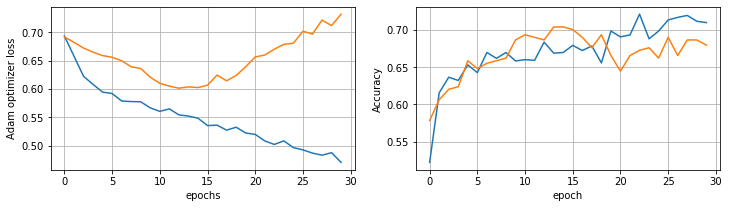


output_dim 64, dropout_rate 0.2, lr 0.001, batch size 32, 30 epochs
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, None, 64)          163776    
                                                                 
 spatial_dropout1d_30 (Spati  (None, None, 64)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_30 (Bat  (None, None, 64)         256       
 chNormalization)                                                
                                                                 
 lstm_30 (LSTM)              (None, 64)                33024     
                                                                 
 dense_41 (Dense)            (None, 2)                 130       
                                                  

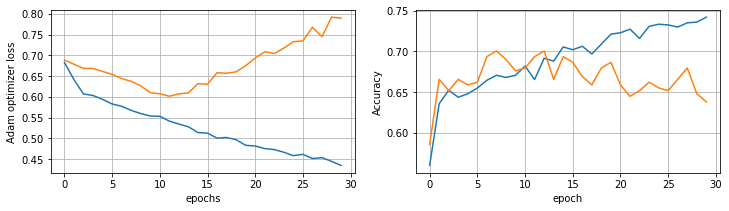


output_dim 128, dropout_rate 0.2, lr 0.001, batch size 32, 30 epochs
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, None, 128)         327552    
                                                                 
 spatial_dropout1d_31 (Spati  (None, None, 128)        0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_31 (Bat  (None, None, 128)        512       
 chNormalization)                                                
                                                                 
 lstm_31 (LSTM)              (None, 64)                49408     
                                                                 
 dense_42 (Dense)            (None, 2)                 130       
                                                 

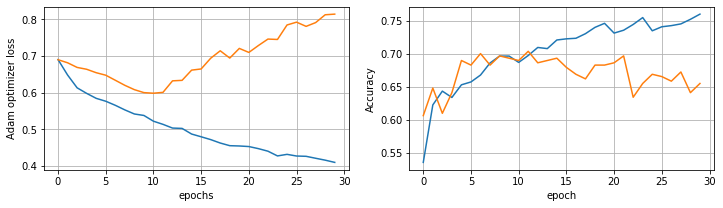

In [110]:
# find the best value for output_dim parameter

epochs = 30
for output_dim in [16, 32, 64, 128]:
    print(f"\noutput_dim {output_dim}, dropout_rate {dropout_rate}, lr {lr}, batch size {batch_size}, {epochs} epochs")
    model = build_model_lstm(vocab_size, output_dim, dropout_rate, lr)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
    assess_model(model, X_test, y_test)     
    plot_accuracy(history)

The model achieves its highest performance with an accuracy of nearly 65% when the output dimension is set to 32. As illustrated in the above plots, the models require fewer than 20 epochs of training to prevent overfitting.


output_dim 32, dropout_rate 0, lr 0.01, batch size 32, 20 epochs
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_32 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_32 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_32 (LSTM)              (None, 64)                24832     
                                                                 
 dense_43 (Dense)            (None, 2)                 130       
                                                     

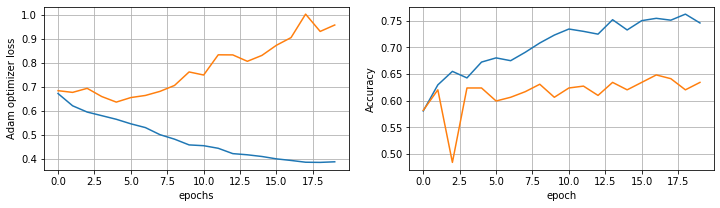

Accuracy:  63.79%
precision score:  0.64
recall score:  0.64
F1 score:  0.64

output_dim 32, dropout_rate 0, lr 0.01, batch size 64, 20 epochs
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_33 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_33 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_33 (LSTM)              (None, 64)                24832     
                                                                 
 dense_44 (Dense)            (None, 2)    

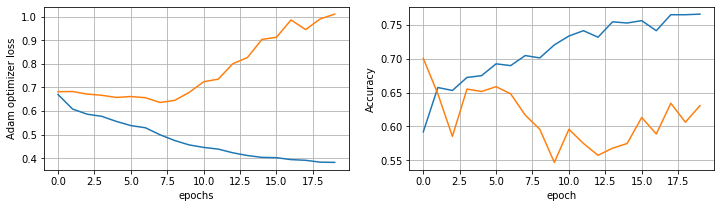

Accuracy:  65.46%
precision score:  0.65
recall score:  0.71
F1 score:  0.68

output_dim 32, dropout_rate 0, lr 0.01, batch size 128, 20 epochs
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_34 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_34 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_34 (LSTM)              (None, 64)                24832     
                                                                 
 dense_45 (Dense)            (None, 2)   

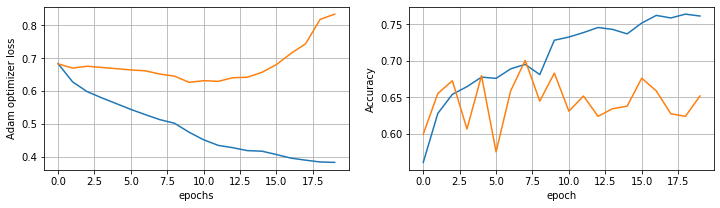

Accuracy:  62.4%
precision score:  0.63
recall score:  0.62
F1 score:  0.63

output_dim 32, dropout_rate 0, lr 0.005, batch size 32, 20 epochs
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_46 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_35 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_35 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_35 (LSTM)              (None, 64)                24832     
                                                                 
 dense_46 (Dense)            (None, 2)    

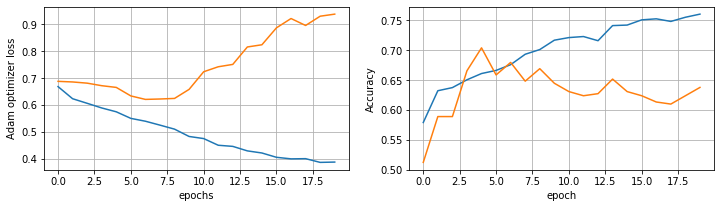

Accuracy:  64.62%
precision score:  0.65
recall score:  0.66
F1 score:  0.65

output_dim 32, dropout_rate 0, lr 0.005, batch size 64, 20 epochs
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_36 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_36 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_36 (LSTM)              (None, 64)                24832     
                                                                 
 dense_47 (Dense)            (None, 2)   

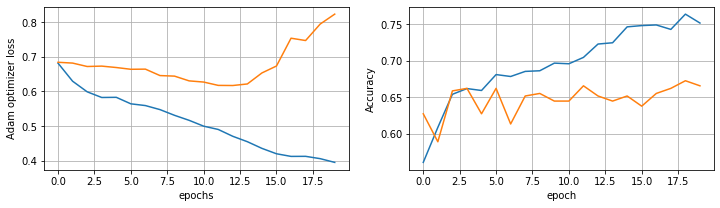

Accuracy:  63.51%
precision score:  0.62
recall score:  0.74
F1 score:  0.67

output_dim 32, dropout_rate 0, lr 0.005, batch size 128, 20 epochs
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_37 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_37 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_37 (LSTM)              (None, 64)                24832     
                                                                 
 dense_48 (Dense)            (None, 2)  

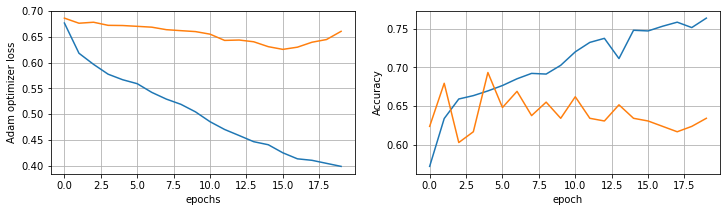

Accuracy:  59.61%
precision score:  0.59
recall score:  0.69
F1 score:  0.63

output_dim 32, dropout_rate 0, lr 0.001, batch size 32, 20 epochs
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_38 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_38 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_38 (LSTM)              (None, 64)                24832     
                                                                 
 dense_49 (Dense)            (None, 2)   

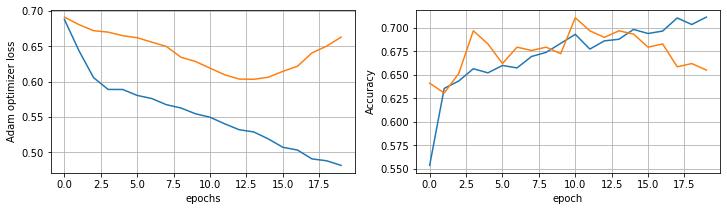

Accuracy:  64.9%
precision score:  0.63
recall score:  0.76
F1 score:  0.69

output_dim 32, dropout_rate 0, lr 0.001, batch size 64, 20 epochs
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_39 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_39 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_39 (LSTM)              (None, 64)                24832     
                                                                 
 dense_50 (Dense)            (None, 2)    

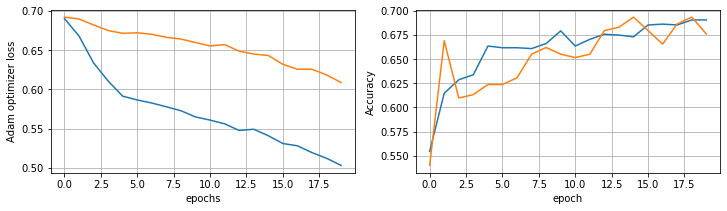

Accuracy:  61.56%
precision score:  0.63
recall score:  0.61
F1 score:  0.62

output_dim 32, dropout_rate 0, lr 0.001, batch size 128, 20 epochs
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_40 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_40 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_40 (LSTM)              (None, 64)                24832     
                                                                 
 dense_51 (Dense)            (None, 2)  

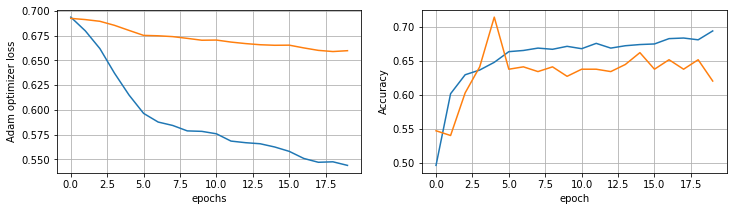

Accuracy:  61.0%
precision score:  0.57
recall score:  0.92
F1 score:  0.71

output_dim 32, dropout_rate 0.2, lr 0.01, batch size 32, 20 epochs
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_52 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_41 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_41 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_41 (LSTM)              (None, 64)                24832     
                                                                 
 dense_52 (Dense)            (None, 2)   

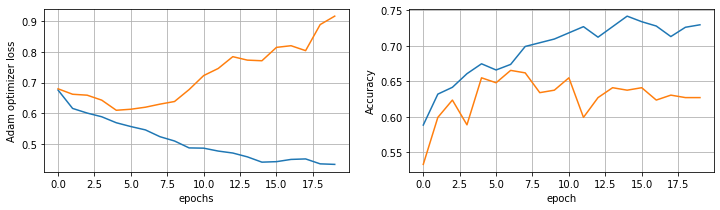

Accuracy:  61.84%
precision score:  0.6
recall score:  0.73
F1 score:  0.66

output_dim 32, dropout_rate 0.2, lr 0.01, batch size 64, 20 epochs
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_53 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_42 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_42 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_42 (LSTM)              (None, 64)                24832     
                                                                 
 dense_53 (Dense)            (None, 2)   

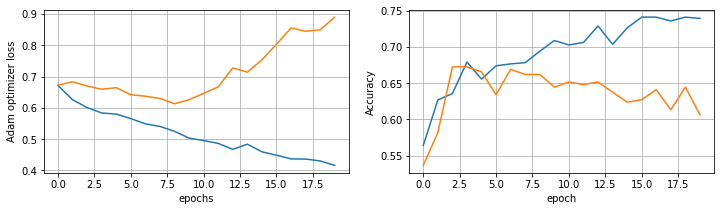

Accuracy:  61.56%
precision score:  0.61
recall score:  0.69
F1 score:  0.65

output_dim 32, dropout_rate 0.2, lr 0.01, batch size 128, 20 epochs
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_54 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_43 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_43 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_43 (LSTM)              (None, 64)                24832     
                                                                 
 dense_54 (Dense)            (None, 2) 

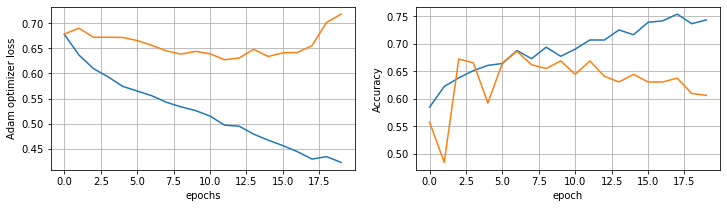

Accuracy:  60.45%
precision score:  0.58
recall score:  0.78
F1 score:  0.67

output_dim 32, dropout_rate 0.2, lr 0.005, batch size 32, 20 epochs
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_55 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_44 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_44 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_44 (LSTM)              (None, 64)                24832     
                                                                 
 dense_55 (Dense)            (None, 2) 

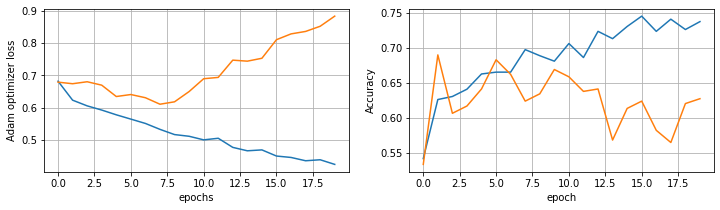

Accuracy:  63.51%
precision score:  0.62
recall score:  0.71
F1 score:  0.66

output_dim 32, dropout_rate 0.2, lr 0.005, batch size 64, 20 epochs
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_56 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_45 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_45 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_45 (LSTM)              (None, 64)                24832     
                                                                 
 dense_56 (Dense)            (None, 2) 

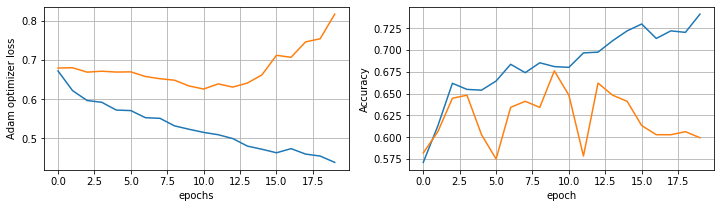

Accuracy:  63.23%
precision score:  0.61
recall score:  0.77
F1 score:  0.68

output_dim 32, dropout_rate 0.2, lr 0.005, batch size 128, 20 epochs
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_57 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_46 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_46 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_46 (LSTM)              (None, 64)                24832     
                                                                 
 dense_57 (Dense)            (None, 2)

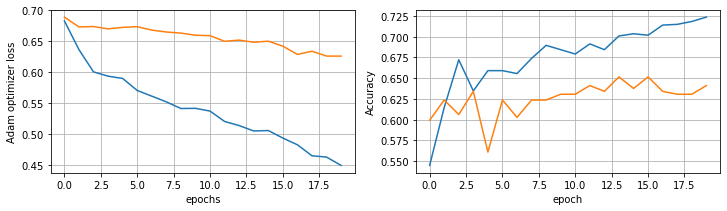

Accuracy:  61.28%
precision score:  0.58
recall score:  0.89
F1 score:  0.7

output_dim 32, dropout_rate 0.2, lr 0.001, batch size 32, 20 epochs
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_58 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_47 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_47 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_47 (LSTM)              (None, 64)                24832     
                                                                 
 dense_58 (Dense)            (None, 2)  

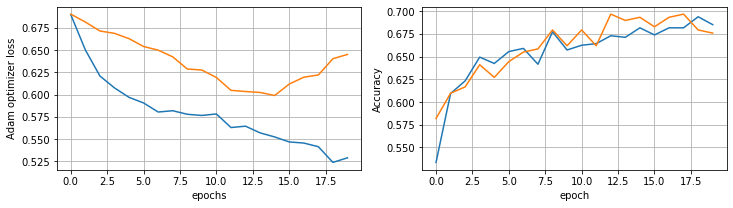

Accuracy:  63.51%
precision score:  0.6
recall score:  0.83
F1 score:  0.7

output_dim 32, dropout_rate 0.2, lr 0.001, batch size 64, 20 epochs
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_59 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_48 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_48 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_48 (LSTM)              (None, 64)                24832     
                                                                 
 dense_59 (Dense)            (None, 2)   

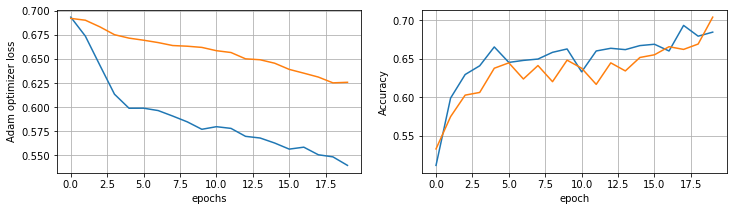

Accuracy:  63.51%
precision score:  0.61
recall score:  0.77
F1 score:  0.68

output_dim 32, dropout_rate 0.2, lr 0.001, batch size 128, 20 epochs
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_60 (Embedding)    (None, None, 32)          81888     
                                                                 
 spatial_dropout1d_49 (Spati  (None, None, 32)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_49 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 lstm_49 (LSTM)              (None, 64)                24832     
                                                                 
 dense_60 (Dense)            (None, 2)

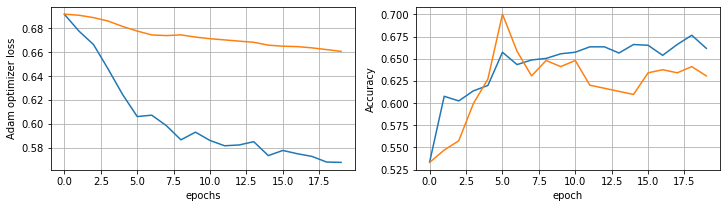

Accuracy:  60.72%
precision score:  0.57
recall score:  0.93
F1 score:  0.71


In [111]:
# Now let's train the model with an output_dim of 32 and explore different combinations of learning rate and batch size parameters. 
epochs = 20
output_dim = 32

for dropout_rate in [0, 0.2]:
    for lr in [0.01, 0.005, 0.001]:
        for batch_size in [32, 64, 128]:
            print(f"\ndropout_rate {dropout_rate}, lr {lr}, batch size {batch_size}, {epochs} epochs")
            model = build_model_lstm(vocab_size, output_dim, dropout_rate, lr)
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
            plot_accuracy(history)
            assess_model(model, X_test, y_test)


None of the tested parameters values performs significantly better then the other. The best accuracy achieved by the model is 65.5%

**Convolutional Model**

Layers: Embegging -> Convolutional -> MaxPooling ->Dense 

In [74]:
model_cv = Sequential()
model_cv.add(layers.Embedding(input_dim=vocab_size, output_dim=output_dim))
model_cv.add(layers.Conv1D(filters=32,kernel_size=3,activation='relu'))
model_cv.add(layers.GlobalMaxPool1D())
model_cv.add(layers.Dense(2, activation='softmax'))

# compile model
model_cv.compile(optimizer = Adam(lr), loss = 'binary_crossentropy', metrics = ['accuracy'])    
model_cv.summary()  

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, None, 32)          81888     
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          3104      
                                                                 
 global_max_pooling1d_5 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_32 (Dense)            (None, 2)                 66        
                                                                 
Total params: 85,058
Trainable params: 85,058
Non-trainable params: 0
_________________________________________________________________


In [75]:
history_cv = model_cv.fit(X_train, y_train, epochs= 30, batch_size=batch_size, validation_split=0.2, verbose=0)

Epoch 1/30
9/9 [==============================] - 1s 30ms/step - loss: 0.6936 - accuracy: 0.4943 - val_loss: 0.6917 - val_accuracy: 0.5436
Epoch 2/30
9/9 [==============================] - 0s 10ms/step - loss: 0.6910 - accuracy: 0.5850 - val_loss: 0.6896 - val_accuracy: 0.6132
Epoch 3/30
9/9 [==============================] - 0s 9ms/step - loss: 0.6887 - accuracy: 0.6312 - val_loss: 0.6872 - val_accuracy: 0.6585
Epoch 4/30
9/9 [==============================] - 0s 9ms/step - loss: 0.6861 - accuracy: 0.6408 - val_loss: 0.6843 - val_accuracy: 0.6585
Epoch 5/30
9/9 [==============================] - 0s 10ms/step - loss: 0.6824 - accuracy: 0.6513 - val_loss: 0.6800 - val_accuracy: 0.6516
Epoch 6/30
9/9 [==============================] - 0s 10ms/step - loss: 0.6776 - accuracy: 0.6565 - val_loss: 0.6744 - val_accuracy: 0.6481
Epoch 7/30
9/9 [==============================] - 0s 13ms/step - loss: 0.6711 - accuracy: 0.6574 - val_loss: 0.6664 - val_accuracy: 0.6481
Epoch 8/30
9/9 [=============

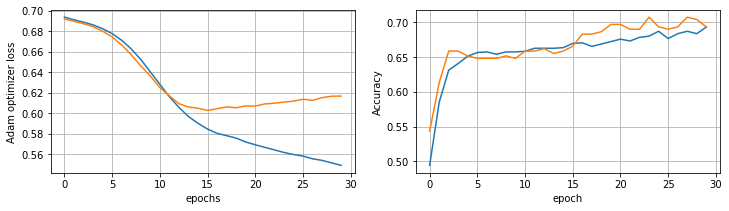

In [76]:
plot_accuracy(history_cv)

In [112]:
assess_model(model_cv, X_test, y_test)

Accuracy:  64.62%
precision score:  0.65
recall score:  0.67
F1 score:  0.66


The loss and accuracy graphs above show good performance of this model, with a final accuracy of 64.6%

##  Make  predictions

In [81]:
# This is a very small set of completed new data to use to make predictions.
prediction_data = ["this book is fabulous","i hated this book", "the best", "no good", "okay", "horrible", "very very good"]
tokenized = tokenizer.texts_to_sequences(prediction_data)
maxlen = 4
padded = pad_sequences(tokenized, padding='post', maxlen=maxlen)

# Supply this data to each of your models 
# Need to call the helper function "to_word_label" to map the output of the model to the name 
# of the class it was predicted to belong to.

y_pred = model_d(padded)
print("Dense model :",to_word_label(y_pred))

y_pred = model_lstm(padded)
print("SLTM model: ",to_word_label(y_pred))

y_pred = model_cv(padded)
print("Convolutional model: ",to_word_label(y_pred))

Dense model : ['negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive']
SLTM model:  ['negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive']
Convolutional model:  ['negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive']


The results indicate that all three models produced identical predictions, achieving an accuracy rate of 57% by correctly classifying 4 out of 7 reviews. This aligns well with the performance measurements, which demonstrated that none of the models exhibited a significant advantage over the others, yielding accuracy levels ranging from approximately 63% to 65%. These findings are satisfactory, especially considering that the majority of sentiments expressed in the reviews consist of fewer than 6 words.